In [1]:
import torch
torch.cuda.is_available()

True

## Using yolov7 to obtain keypoints

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import time
from torch.utils.data import Dataset, DataLoader


from torchvision import transforms
from PIL import Image

In [3]:
# Change directory to "/yolov7"
os.chdir("yolov7")
print(os.getcwd()) 

/notebooks/Fighting-detection-in-CCTVs/yolov7


In [4]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###############################################################################

# Load yolov7 pose detector model
print("Loading model: ", "yolov7-pose...")
weights_path = "yolov7-w6-pose.pt"
model_yolov7 = torch.load(weights_path, map_location=device, weights_only=False)['model']
print("Model loaded.")

model_yolov7.float().eval()

if torch.cuda.is_available():
    # half() turns predictions into float16 tensors --> significantly lowers inference time
    model_yolov7.half().to(device)

Loading model:  yolov7-pose...
Model loaded.


In [5]:
# Main inference
def infer(image):
    image = letterbox(image, 960, 
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960])

    if torch.cuda.is_available():
        image = image.half().to(device)

    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    with torch.no_grad():
        output, _ = model_yolov7(image)

    return output, image

###############################################################################
# Draw YOLOv7 pose keypoints and optionally return keypoints for saving.
def draw_keypoints(output, image, confidence=0.25, threshold=0.65, return_kpts=False, background_colour=(255, 255, 255)):
    output = non_max_suppression_kpt(
        output,
        confidence,
        threshold,
        nc=model_yolov7.yaml['nc'],
        nkpt=model_yolov7.yaml['nkpt'],
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)  # shape: (num_people, 51)

    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)
    
    # Create a blank image with the specified background colour
    # nimg = np.full((image.shape[2], image.shape[3], 3), background_colour, dtype=np.uint8)

    # Correctly loop through 'output' variable instead of 'kpts'
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    if return_kpts:
        return nimg, output  # (image with keypoints drawn, raw keypoints)

    return nimg


## Create custom dataloader
- includes pre-processing via yolov7 pose estimator

In [6]:

transform = transforms.Compose([
    # Convert frames to PyTorch tensors
    transforms.ToTensor(), 
    # Resize all video frames to 480, 640 (480p)
    transforms.Resize((480,640)), 
    # Convert to grayscale
    transforms.Grayscale(num_output_channels=1), 
])

class VideoDataset(Dataset):
    def __init__(self, video_files, video_folder, transform=transform):
        self.video_folder = video_folder
        self.video_files = video_files
        self.transform = transform
        self.data = self._load_data()

    
    
    def _load_data(self):
        data = []
        count = 5
        
        for video_file in self.video_files:
            video_path = os.path.join(self.video_folder, video_file)
            # if the video name is "nofixxx.mp4", this means no-fight --> 0
            # if "NV_xx.mp4" means no-fight
            if "nofi" in video_file or "NV" in video_file:
                label = 0
            else:
                label = 1
                
            # Check if we extract the labels correctly
            # if count >= 0:
            #     print(f'video path: {video_path}')
            #     print(f'label: {label}')
            #     count -= 1
                                      
            capture = cv2.VideoCapture(video_path)
            fps = int(capture.get(cv2.CAP_PROP_FPS))
            total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
             
            # for idx in range(0, total_frames, fps): # use this to sample one frame per second
            for idx in range(0, total_frames, fps): # use this to sample all frames in the video
                capture.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = capture.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    keypoints, image = infer(frame_rgb)
                    pose_image = draw_keypoints(keypoints, image, return_kpts=False)
                    
                    # Check the outputs given by yolov7 output
                    # if count >= 0:
                    #     plt.figure(figsize=(30, 7))
                    #     plt.axis("off")
                    #     plt.imshow(pose_image)
                    #     plt.savefig(f"output{count}.jpg") # Save output if needed
                    
                    data.append((pose_image, label))
            capture.release()
        return data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # frame_with_kpts, keypoints, label = self.data[idx]
        pose_image, label = self.data[idx]
        if self.transform:
            pose_image = self.transform(pose_image)
            
            # Check the outputs given by yolov7 output witih the added transformations
            # if count >= 0:
            #     plt.figure(figsize=(30, 7))
            #     plt.axis("off")
            #     plt.imshow(pose_image)
            #     plt.savefig(f"output{count}.jpg") # Save output if needed
                    
        # return frame_with_kpts, keypoints, label
        return pose_image, label


## Prepare video paths and labels

In [14]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

print("Preparing dataloaders...")

video_folder = "../fight-detection-4"
video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".avi", ".mov", ".mpeg"))]

print("Splitting data...")
# Split dataset such that 20% of data is used for testing, remaining 80% for training + validation
train_files, test_files = train_test_split(video_files, test_size=0.2, random_state=42)
# Split dataset such that 60% of data is used for training, remaining 20% for validation
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2


train_dataset = VideoDataset(train_files, video_folder)
print("Train dataset compiled...")
val_dataset = VideoDataset(val_files, video_folder)
print("Validation dataset compiled...")
test_dataset = VideoDataset(test_files, video_folder)
print("Test dataset compiled...")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("Train dataloader compiled...")
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("Validation dataloader compiled...")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Test dataloader compiled...")



Preparing dataloaders...
Splitting data...
Train dataset compiled...
Validation dataset compiled...
Test dataset compiled...
Train dataloader compiled...
Validation dataloader compiled...
Test dataloader compiled...


## Create pytorch instance of ResNet

In [7]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim


# Load a pre-trained ResNet model
model_resnet = models.resnet50(pretrained=True)

# Modify the final layer for binary classification
# --> we apply sigmoid activation during the forward pass or within the loss function
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, 1)


# Freeze the base model parameters
for param in model_resnet.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer parameters
for param in model_resnet.fc.parameters():
    param.requires_grad = True


model_resnet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train MobileNet on fighting and non-fighting datasets
- lr = 0.001
- epochs = 100
- Adam optimiser

In [15]:
# Load the weights from previous epochs
model_resnet.load_state_dict(torch.load('../model_epoch_recent_resnet_data3.pth'))

<All keys matched successfully>

In [16]:
def validate(model, val_loader):
    # Set the model to evaluation mode
    model.eval()  
    val_loss = 0.0
    correct, total = 0, 0
    # Ensure the same loss function is used
    criterion = nn.BCEWithLogitsLoss()  

    # Disable gradient computation
    with torch.no_grad():  
        for pose_img, labels in val_loader:
            # Duplicate the grayscale channel to create a 3-channel image
            pose_img = pose_img.repeat(1, 3, 1, 1) 
            pose_img, labels = pose_img.to(device), labels.to(device).float()
            outputs = model(pose_img)
            
            # Accumulate the loss
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * pose_img.size(0)  
            
            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()

    # Compute the average loss
    val_loss /= len(val_loader.dataset)  
    val_accuracy = correct / total
    return val_loss, val_accuracy

num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define loss function and optimiser
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model_resnet.fc.parameters(), lr=0.0001)

# count = 1


for epoch in range(num_epochs):
    model_resnet.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for pose_img, labels in train_loader:
        # Duplicate the grayscale channel to create a 3-channel image
        pose_img = pose_img.repeat(1, 3, 1, 1) 
        inputs, labels = pose_img.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()
        
        # if count >= 0:
        #     print(f"Predicted value: {predicted.cpu()}")
        #     print(f"Label: {labels.cpu().unsqueeze(1)}")
        #     count -= 1

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation step (assuming val_loader is defined)
    val_loss, val_accuracy = validate(model_resnet, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Save model weights for every 5 epochs
    # if epoch % 5 == 0:
    #     torch.save(model_resnet.state_dict(), f'../model_epoch_2_{epoch+1}.pth')

Predicted value: tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]], grad_fn=<ToCopyBackward0>)
Label: tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]])
Predicted value: tensor([[0.],
        [0.],
      

## Save model weights

In [17]:
torch.save(model_resnet.state_dict(), f'../model_epoch_recent_resnet_data4.pth')

## Show training-val loss and accuracy over epochs

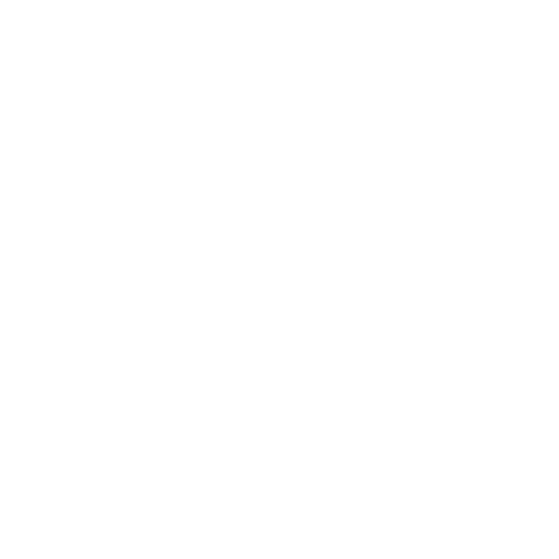

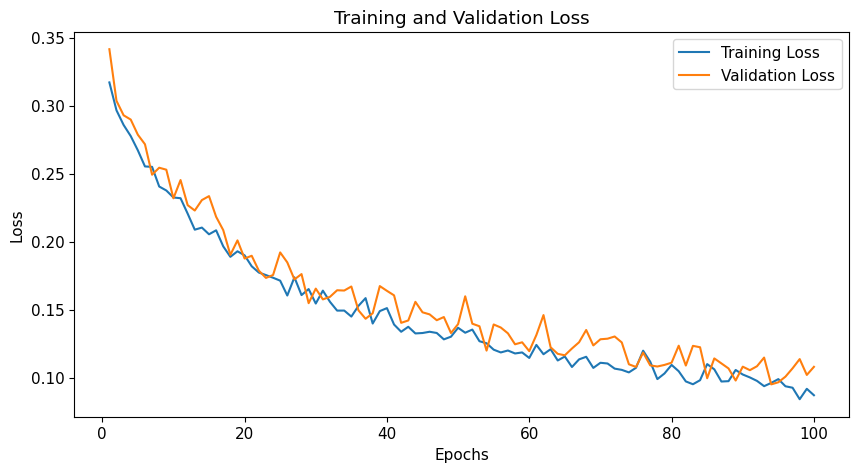

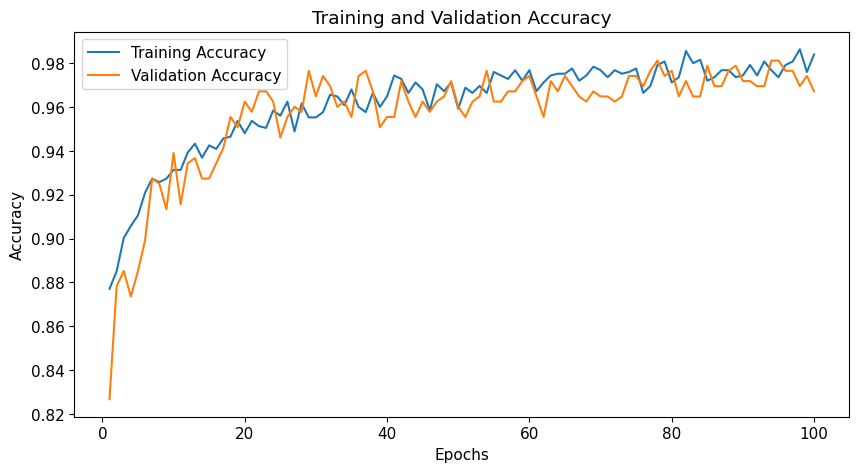

In [18]:
%matplotlib inline

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


### Basic inference and testing

In [12]:
# Load weights
model_resnet.load_state_dict(torch.load('../model_epoch_recent_resnet_data3.pth'))
model_resnet.eval()

###############################################################################

# Pre-process input --> extract frames
video_path = '../fight-detection-2/nofi096.mp4'

###############################################################################

class Video(Dataset):
    def __init__(self, video_path, transform=transform):
        self.video_path = video_path
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        data = []
                                      
        capture = cv2.VideoCapture(self.video_path)
        fps = int(capture.get(cv2.CAP_PROP_FPS))
        total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

        # for idx in range(0, total_frames, fps): # use this to sample one frame per second
        for idx in range(0, total_frames, fps): # use this to sample all frames in the video
            capture.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = capture.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                keypoints, image = infer(frame_rgb)
                pose_image = draw_keypoints(keypoints, image, return_kpts=False)
                data.append(pose_image)
        capture.release()
        return data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pose_image = self.data[idx]
        if self.transform:
            pose_image = self.transform(pose_image)
        return pose_image

###############################################################################
processed_video = Video(video_path)
print("Video compiled...")

video_loader = DataLoader(processed_video, batch_size=32, shuffle=True)     
print("Video loaded...")
        
# Inference
for pose_img in video_loader:
    # Duplicate the grayscale channel to create a 3-channel image
    pose_img = pose_img.repeat(1, 3, 1, 1) 
    pose_img = pose_img.to(device)
    outputs = model_resnet(pose_img)
    predicted = torch.round(torch.sigmoid(outputs))
    print(f"Predicted result for batch: {predicted}")

Video compiled...
Video loaded...
Predicted result for batch: tensor([[1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)


## Testloader
- can be used for unseen dataset
- or for the 20% split dataset done earlier

In [9]:
from sklearn.metrics import f1_score


# Load weights
model_resnet.load_state_dict(torch.load('../model_epoch_recent_resnet_data4.pth'))
model_resnet.eval()

###############################################################################

# Use the Dataloader for unseen dataset - comment out this portion otherwise
print("Preparing a new test dataloader...")

video_folder = "../fight-detection-5"
video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".avi", ".mov", ".mpeg"))]

test_dataset = VideoDataset(video_files, video_folder)
print("Test dataset compiled...")

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Test dataloader compiled...")

###############################################################################

def test(model, test_loader=test_loader):
    test_loss = 0.0
    correct, total = 0, 0
    
    all_labels = []
    all_predictions = []
    
    criterion = nn.BCEWithLogitsLoss()  # Ensure the same loss function is used

    with torch.no_grad():  # Disable gradient computation
        for pose_img, labels in test_loader:
            pose_img = pose_img.repeat(1, 3, 1, 1) # Duplicate the grayscale channel to create a 3-channel image
            pose_img, labels = pose_img.to(device), labels.to(device).float()
            outputs = model(pose_img)
            
            # Accumulate the loss
            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item() * pose_img.size(0)  
            
            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()
            
            # Collate lables and predictions into numpy for f1 score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute the average loss
    test_loss /= len(test_loader.dataset)  
    test_accuracy = correct / total
    test_f1_score = f1_score(all_labels, all_predictions)
    return test_loss, test_accuracy, test_f1_score

test_loss, test_accuracy, test_f1_score = test(model_resnet)
print(f"Test loss: {test_loss} Test accuracy: {test_accuracy} F1 score: {test_f1_score}")

Preparing a new test dataloader...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[h264 @ 0xcc72800] mb_type 104 in P slice too large at 98 31
[h264 @ 0xcc72800] error while decoding MB 98 31
[h264 @ 0xcc72800] mb_type 104 in P slice too large at 98 31
[h264 @ 0xcc72800] error while decoding MB 98 31


Test dataset compiled...
Test dataloader compiled...


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test loss: 0.45330642301067964 Test accuracy: 0.7807167235494881 F1 score: 0.7774891774891776
